# PCLab#3 - Group 1 - Johannes, Petter, and Oskar

Big picture context
- You’ve just been hired by a sophisticated hedge-fund
- The hedge-fund manager is interested in Twitter’s predictive power
- He asks you to perform sentiment analysis on a sample of recent financial tweets...
- ... and to build a firm-level measure of media attention: that may be a great factor idea !

Packages you may need
- Among others: wordcloud, nltk.stem, nltk.corpus, nltk.tokenize, gensim, tensorflow, string.punctuation, sklearn, etc.

In [1]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm

import re
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import class_weight


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

import seaborn as sns

from transformers import BertTokenizer, TFBertTokenizer, BertForSequenceClassification, TFBertForSequenceClassification
from transformers import pipeline


/Users/oskarkrafft/.local/share/virtualenvs/Finance_with_Big_Data_lab3-DrEdNN_c/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Task #1: Basic manipulation and descriptive statistics
- Import the Data_PCLab3_Twitter_Stock_Sentiment.csv data and describe the sample (data available on BBoard)
- How many tweets, how many words per tweets, distribution of number of words per tweets, average sentiment, etc.

In [2]:
# load the data
twitter_df = pd.read_csv('./data/Data_PCLab3_Twitter_Stock_Sentiment.csv')
twitter_df.head(n=10)

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
5,PGNX Over 3.04,1
6,AAP - user if so then the current downtrend wi...,0
7,Monday's relative weakness. NYX WIN TIE TAP IC...,0
8,GOOG - ower trend line channel test & volume s...,1
9,AAP will watch tomorrow for ONG entry.,1


In [3]:
twitter_df.describe()

,Sentiment
count,5791.000000
mean,0.636332
std,0.481096
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [4]:
twitter_df.isnull().sum()

Text         0
Sentiment    0
dtype: int64

In [5]:
# How many tweets?
print(f'How many tweets? There are {len(twitter_df)} tweets in the dataset')

# How many words per tweet?
words_per_tweet = twitter_df['Text'].apply(lambda x: len(x.split()))
print(f'How many words per tweet? There are {words_per_tweet.mean():.2f} words on average per tweet')
print(f'Minimum words per tweet: {words_per_tweet.min():.0f}')
print(f'Maximum words per tweet: {words_per_tweet.max():.0f}')

How many tweets? There are 5791 tweets in the dataset
How many words per tweet? There are 14.01 words on average per tweet
Minimum words per tweet: 2
Maximum words per tweet: 32


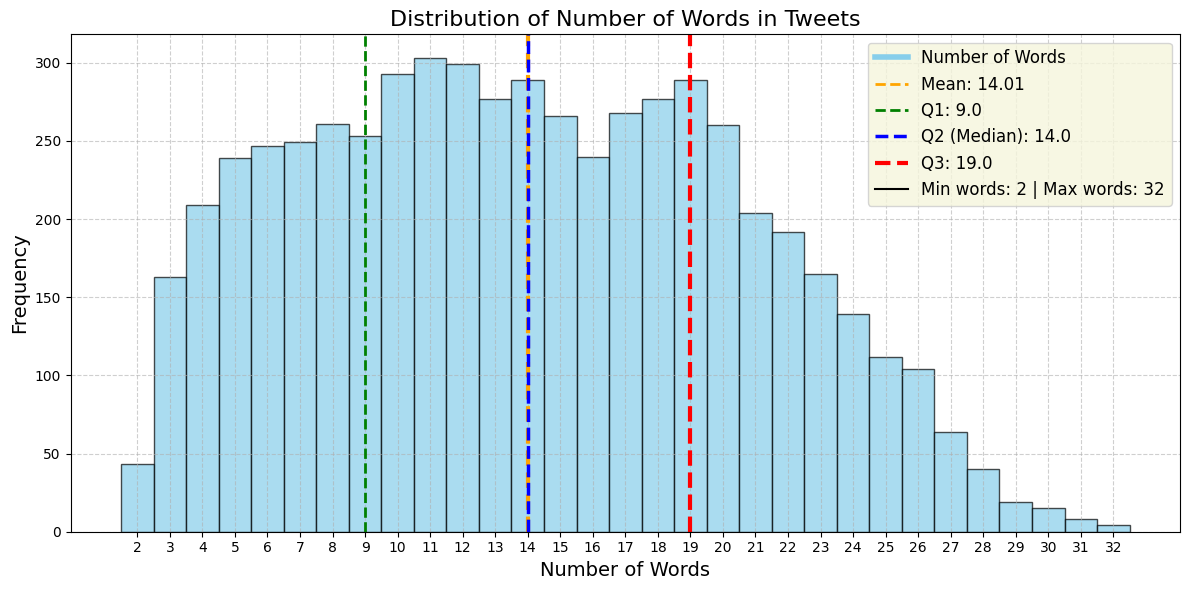

In [6]:
# Create a chart with one bin per word count

# Calculate descriptive statistics
min_words = words_per_tweet.min()
max_words = words_per_tweet.max()
mean_words = words_per_tweet.mean()
quartiles = np.percentile(words_per_tweet, [25, 50, 75])

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.hist(words_per_tweet, bins=np.arange(1.5, 33.5, 1), color='skyblue', edgecolor='black', alpha=0.7)

# Add lines for the descriptive statistics
plt.axvline(mean_words, color='orange', lw=3, linestyle='--', label=f'Mean: {mean_words:.2f}')
plt.axvline(quartiles[0], color='green', lw=2, linestyle='--', label=f'Q1: {quartiles[0]}')
plt.axvline(quartiles[1], color='blue', lw=2.5, linestyle='--', label=f'Q2 (Median): {quartiles[1]}')
plt.axvline(quartiles[2], color='red', lw=3, linestyle='--', label=f'Q3: {quartiles[2]}')

# Set the x-axis ticks to align with the bins
plt.xticks(np.arange(2, 33, 1))

# Add title and label axis
plt.title('Distribution of Number of Words in Tweets', fontsize=16)
plt.xlabel('Number of Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Define legend elements
legend_elements = [
    plt.Line2D([0], [0], color='skyblue', lw=4, label='Number of Words'),
    plt.Line2D([0], [0], color='orange', linestyle='--', lw=2, label=f'Mean: {mean_words:.2f}'),
    plt.Line2D([0], [0], color='green', linestyle='--', lw=2, label=f'Q1: {quartiles[0]}'),
    plt.Line2D([0], [0], color='blue', linestyle='--', lw=2.5, label=f'Q2 (Median): {quartiles[1]}'),
    plt.Line2D([0], [0], color='red', linestyle='--', lw=3, label=f'Q3: {quartiles[2]}'),
    plt.Line2D([0], [0], color='black', label=f'Min words: {min_words} | Max words: {max_words}')
]

# Move the legend to the top-right corner inside the plot
plt.legend(facecolor='beige', handles=legend_elements, loc='upper right', fontsize=12)

# Plot the chart
plt.tight_layout()
plt.show()

#### Describe the dataset
The dataset consists of 5791 tweets along with their corresponding sentiment values.

The dataset is structured with two columns:
- Text: This column contains the actual text content of each tweet.
- Sentiment: This column represents the sentiment associated with each tweet, with '1' indicating positive sentiment and '0' indicating negative sentiment.

##### Descriptive Statistics
- Average words per tweet: 14.01 words
- Average sentiment: 0.6363
- Minimum words per tweet: 2
- Maximum words per tweet: 32
- Distribution of words per tweet: Most tweets are between 5 and 23 tweets.Tweets rarely are longer than 25 words.

## Task #2 : Cleaning and visualization
- Usual cleaning steps: remove punctuation, stopwords, short words, etc.
- Try your cleaning on this sentence: $I love AI & Machine learning applied to Finance...!! ;)
- Plot a word cloud for text with positive and negative sentiment separately
- What is the number of unique words ?

In [7]:
# download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oskarkrafft/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
stop_words = set(stopwords.words('english'))
port_stem = PorterStemmer()

In [9]:
def text_cleaning(text):
    """
    Cleans the given text by removing special characters and numbers, converting it to lowercase,
    tokenizing the text, stemming the words, and removing stopwords.

    Args:
        text (str): The text to be cleaned.

    Returns:
        str: The cleaned text.
    """
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    words = text.split()
    words = [port_stem.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

In [10]:
# apply text cleaning to the text column of the data
twitter_df['clean_text'] = twitter_df['Text'].apply(text_cleaning)
    
# separate positive and negative tweets
positive_tweets = ' '.join(twitter_df[twitter_df['Sentiment'] == 1]['clean_text'])
negative_tweets = ' '.join(twitter_df[twitter_df['Sentiment'] == 0]['clean_text'])

In [11]:
# Cleaning this sentence: $I love AI & Machine learning applied to Finance...!! ;)
sentence = '$I love AI & Machine learning applied to Finance...!! ;)'

text_cleaning(sentence)

'love ai machin learn appli financ'

In [12]:
def plot_wordcloud(text, title):
    """
    Generate and display a word cloud based on the given text.

    Parameters:
    text (str): The text to generate the word cloud from.
    title (str): The title of the word cloud plot.

    Outputs:
    Visualisation of plot
    """
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

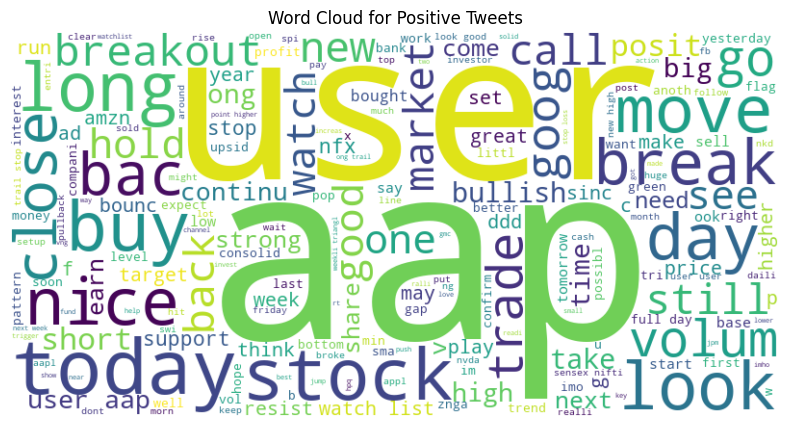

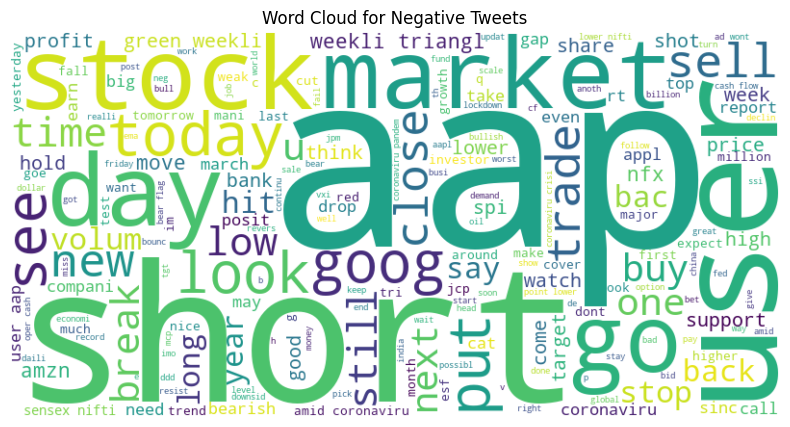

In [13]:
# create wordcloud
plot_wordcloud(positive_tweets, 'Word Cloud for Positive Tweets')
plot_wordcloud(negative_tweets, 'Word Cloud for Negative Tweets')

In [14]:
# function to count all occurances of each word in a list of sentences
def word_counter(list):
    """
    Counts the frequency of each word in a list of sentences.

    Parameters:
    list (list): A list of sentences.

    Returns:
    dict: A dictionary where the keys are words and the values are the frequency of each word.
    """
    word_map = {}
    for sentence in list:
        for word in sentence.split():
            if word in word_map:
                word_map[word] +=1
            else:
                word_map[word] = 1
    return word_map

In [15]:
# what is the number of unique words? Answer: 7511
clean_text_list = twitter_df['clean_text'].tolist()
word_map = word_counter(clean_text_list)
word_map = sorted(word_map.items(), key=lambda x:x[1], reverse=True) # sort word_map
print(f'Number of unique words: {len(word_map)}')

Number of unique words: 7511


**Comment on results:**
Not excluding tickers is a problem, as ticker such as AAP and GOOG are important words for both positive and negative sentiment tweets. This is likely a direct result of them both being big and liquid firms.

Furthermore, excluding numbers is not the best way to gain insight on sentiment. Consider this tweet: "AAPL target: 100". If the current price is 50, this is a positive sentiment, but if the price is 200, this is a negative sentiment. Thus, incorporating numbers may yield good results. However, this may lead to other problems due to the significant increase in complexity.

## Task #3 : Sentment analysis
If any of those steps are not crystal clear, please tell me now (or shoot me an email soon after the class)
- More usual steps: Tokenizing the text and padding
    - Tokenize: vectorize text corpus, transform text into numbers
    - Padding: make all sentences the same lenght (fill with 0 short sentences)
- Split the sample in a train / test dataset (test = 10% of the total sample)
- Train model of your choice (RNN, LTSM, etc.) to predict the sentiment (1 or 0) on the test sample (you could use embedding layer to reduce the dimension of the problem)
- Plot the confusion matrix and compute the accuracy score (e.g., with sklearn function accuracy)

**Checking class balance**

Sentiment
1    3685
0    2106
Name: count, dtype: int64
Sentiment
1    63.633224
0    36.366776
Name: proportion, dtype: float64


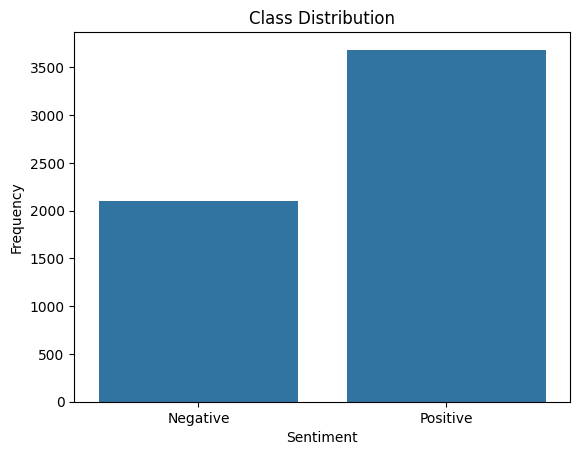

In [16]:
# check class balance
class_distribution = twitter_df['Sentiment'].value_counts()
print(class_distribution)

# To see the percentage distribution
class_percentage = twitter_df['Sentiment'].value_counts(normalize=True) * 100
print(class_percentage)

sns.countplot(x='Sentiment', data=twitter_df)
plt.title('Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

we can observe that the dataset is unbalanced. Typical threshold being 40% > for one class.

**Tokenization and Padding**

In [17]:
# Initialize the tokenizer
tokenizer = Tokenizer(num_words=len(word_map))  # Consider all the unique words
tokenizer.fit_on_texts(twitter_df['clean_text'])  # Fit on the cleaned text data

# convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(twitter_df['clean_text'])

# pad the sequences to ensure equal length
max_len = 32  # as there were at most 32 words in a single tweet
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

**Train-Test Split**

In [18]:
X = padded_sequences # the independent variables used to predict y
y = twitter_df['Sentiment'].values # the dependent variable

# split into 90% training and 10% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1337)

In [19]:
# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}  # Convert to dictionary
print(f'Class Weights: {class_weights_dict}')

Class Weights: {0: 1.3713157894736843, 1: 0.7869223799456357}


**Train a model of our choice (LSTM)**

In [20]:
model = Sequential() # define a sequential model

model.add(Embedding(input_dim=len(word_map), output_dim=64)) # turns the input into a dense vector of fixed size

model.add(LSTM(units=64, return_sequences=False)) # add LSTM layer

model.add(Dropout(0.5)) # add dropout for regularization - at 0.5 probability, the network drops a unit

model.add(Dense(1, activation='sigmoid')) # add a dense layer for the output and use the sigmoid function to get probabilities

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # compile the model

model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1, class_weight=class_weights_dict) # train the model with the class weights

Epoch 1/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5705 - loss: 0.6896 - val_accuracy: 0.3621 - val_loss: 0.6971
Epoch 2/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4709 - loss: 0.6872 - val_accuracy: 0.7433 - val_loss: 0.5986
Epoch 3/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8202 - loss: 0.4825 - val_accuracy: 0.7586 - val_loss: 0.5111
Epoch 4/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8989 - loss: 0.2976 - val_accuracy: 0.7184 - val_loss: 0.5793
Epoch 5/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9324 - loss: 0.2073 - val_accuracy: 0.7720 - val_loss: 0.5571


**Evaluate and Confusion-Matrix**

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.75


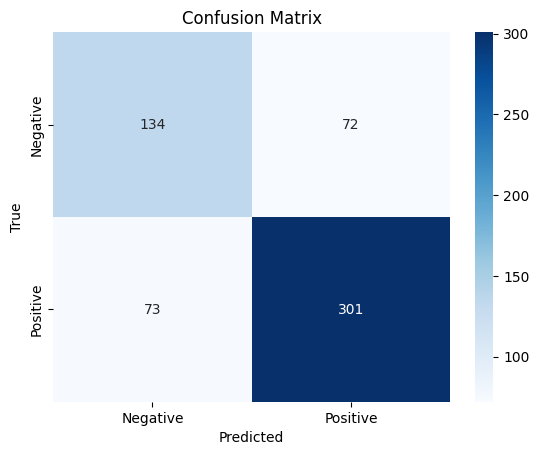

In [21]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).flatten() # convert probabilities to binary

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [22]:
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.65      0.65      0.65       206
    Positive       0.81      0.80      0.81       374

    accuracy                           0.75       580
   macro avg       0.73      0.73      0.73       580
weighted avg       0.75      0.75      0.75       580




## Task #4 : Sentment analysis - Optional
- Use transformers (BERT from Huggingface) to perform another sentiment analysis and compare to the sentiment value in the data
    - Use pipeline: from transformers import pipeline
    - Use the already created library: text-classification or sentiment-analysis
- What is the performance of the algorithm on financial tweets ? I.e., how does BERT classifies the Tweets compared to the original classification you have ?
- Hint: check the Huggingface website
- To go further: check FinBERT

In [23]:
# Initialize Huggingface sentiment-analysis pipeline (BERT-based model)
classifier = pipeline("sentiment-analysis")

# Apply BERT sentiment analysis on each tweet
bert_sentiments = []
for tweet in twitter_df['clean_text']:
    result = classifier(tweet)[0]  # Get the first result (it's a list of dictionaries)
    bert_sentiments.append(1 if result['label'] == 'POSITIVE' else 0)

# Add BERT sentiments to the dataframe
twitter_df['BERT_Sentiment'] = bert_sentiments

# Compare BERT's sentiments with the original sentiment labels
print("BERT vs Original Sentiment Classification Report")
print(classification_report(twitter_df['Sentiment'], twitter_df['BERT_Sentiment'], target_names=['Negative', 'Positive']))

# samples where BERT disagrees with the original label:
disagreements = twitter_df[twitter_df['Sentiment'] != twitter_df['BERT_Sentiment']]
print(disagreements[['clean_text', 'Sentiment', 'BERT_Sentiment']].head())

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


BERT vs Original Sentiment Classification Report
              precision    recall  f1-score   support

    Negative       0.40      0.90      0.56      2106
    Positive       0.81      0.23      0.36      3685

    accuracy                           0.48      5791
   macro avg       0.61      0.57      0.46      5791
weighted avg       0.66      0.48      0.43      5791

                                          clean_text  Sentiment  \
0  kicker watchlist xide tit soq pnk cpw bpz aj t...          1   
1  user aap movi return feage indic trade year aw...          1   
2  user id afraid short amzn look like nearmonopo...          1   
3                                               mnta          1   
5                                               pgnx          1   

   BERT_Sentiment  
0               0  
1               0  
2               0  
3               0  
5               0  


In [46]:
# Load the PyTorch version of FinBERT
finbert_model = BertForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone", num_labels=3)
finbert_tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")

# Create the pipeline using PyTorch
finbert_classifier = pipeline("sentiment-analysis", model=finbert_model, tokenizer=finbert_tokenizer, framework="pt")

# Now apply FinBERT sentiment analysis on each tweet
finbert_sentiments = []
for tweet in twitter_df['clean_text']:
    result = finbert_classifier(tweet)[0]  # Get the first result (it's a list of dictionaries)
    if result['label'] == 'positive':
        finbert_sentiments.append(1)
    elif result['label'] == 'negative':
        finbert_sentiments.append(0)
    else:
        finbert_sentiments.append(2)

# Add FinBERT sentiments to the dataframe
twitter_df['FinBERT_Sentiment'] = finbert_sentiments

RuntimeError: Error(s) in loading state_dict for BertForSequenceClassification:
	size mismatch for classifier.weight: copying a param with shape torch.Size([3, 768]) from checkpoint, the shape in current model is torch.Size([2, 768]).
	size mismatch for classifier.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([2]).
	You may consider adding `ignore_mismatched_sizes=True` in the model `from_pretrained` method.

In [45]:
twitter_df["FinBERT_Sentiment"].unique()

array([2])

In [42]:
# Create a DataFrame to compare the sentiments
comparison_df = pd.DataFrame({'Original Sentiment': twitter_df['Sentiment'],
                              'BERT Sentiment': twitter_df['BERT_Sentiment'],
                              'FinBERT Sentiment': twitter_df['FinBERT_Sentiment']})

# Display the comparison DataFrame
print(comparison_df)

      Original Sentiment  BERT Sentiment  FinBERT Sentiment
0                      1               0                  2
1                      1               0                  2
2                      1               0                  2
3                      1               0                  2
4                      1               1                  2
...                  ...             ...                ...
5786                   0               0                  2
5787                   0               0                  2
5788                   1               0                  2
5789                   1               0                  2
5790                   1               0                  2

[5791 rows x 3 columns]


In [43]:
# Calculate accuracy for FinBERT
finbert_agreement = (comparison_df['Original Sentiment'] == comparison_df['FinBERT Sentiment']).mean()

# Calculate accuracy for BERT
bert_agreement = (comparison_df['Original Sentiment'] == comparison_df['BERT Sentiment']).mean()

finbert_agreement, bert_agreement

(0.0, 0.47798307718874117)

**Results**
The finbert is poor at predicting, given the data we apply it to. For ~90% of the instances, finbert predicts negative sentiment.

## Task #5 : Measuring media attention
- Use the list of tickers gathered during last PC Lab (see the web-scrapping part) to compute the number of tweets about each stock
    - e.g., AAPL: 36 tweets, 12 negative, 24 positive
- Rank the stocks by their amount of total media attention, positive and negative media attention
- Optional: Using the stock prices data on our 8 stocks (or more from the web-scrapping task), do you see a correlation between media attention and excess return ?
- If yes, could Twitter attention is likely to be a good factor ?

**Collect Tickers**

In [47]:
# Load S&P 500 company list from Wikipedia
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

# Replace '.' with '-' in symbols (needed for Yahoo Finance compatibility)
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

# Create a list of unique symbols
symbol_list = sp500['Symbol'].unique().tolist()

# Replace AAPL by AAP, as AAP is the ticker used for Apple in the twitter data
symbol_list = ['AAP' if ticker == 'AAPL' else ticker for ticker in symbol_list]

In [48]:
def calculate_ticker_mentions(twitter_df, symbol_list):
    """
    Calculates the number of mentions and positive mentions of each ticker symbol in a Twitter dataframe.

    Parameters:
    - twitter_df (pandas.DataFrame): The Twitter dataframe containing the tweets.
    - symbol_list (list): A list of ticker symbols to calculate mentions for.

    Returns:
    - ticker_df (pandas.DataFrame): A dataframe with the number of mentions and positive mentions for each ticker symbol.
    """
    ticker_df = pd.DataFrame(index=symbol_list, columns=['mentions', 'positive'])
    ticker_df['mentions'] = 0
    ticker_df['positive'] = 0

    for i, row in twitter_df.iterrows():
        for ticker in symbol_list:
            if ticker in row['Text'].split():
                ticker_df.loc[ticker, 'mentions'] += 1

                if row['Sentiment'] == 1:
                    ticker_df.loc[ticker, 'positive'] += 1

    return ticker_df


In [49]:
ticker_df = calculate_ticker_mentions(twitter_df, symbol_list)

**Rank stocks after total media attention, positive mentions, and negative mentions**

In [50]:
ticker_df['negative'] = ticker_df['mentions'] - ticker_df['positive'] # create 'negative' column

ranked_mentions = ticker_df.sort_values('mentions', ascending=False) # Rank based on total media attention (mentions)

ranked_positive = ticker_df.sort_values('positive', ascending=False) # Rank based on positive mentions

ranked_negative = ticker_df.sort_values('negative', ascending=False) # Rank based on negative mentions

In [51]:
print('Top 5 Total Mentions:\n', ranked_mentions.head(5))
print('\nTop 5 Positive Mentions:\n', ranked_positive.head(5))
print('\nTop 5 Negative Mentions:\n', ranked_negative.head(5))

Top 5 Total Mentions:
       mentions  positive  negative
AAP        850       466       384
BAC        198       150        48
GOOG       184       114        70
AMZN        97        54        43
A           85        49        36

Top 5 Positive Mentions:
       mentions  positive  negative
AAP        850       466       384
BAC        198       150        48
GOOG       184       114        70
AMZN        97        54        43
A           85        49        36

Top 5 Negative Mentions:
       mentions  positive  negative
AAP        850       466       384
GOOG       184       114        70
BAC        198       150        48
AMZN        97        54        43
A           85        49        36


**Comment**
These results are not that interesting as we are more interested in the proporation of positive vs. negative mentions.

In [52]:
ticker_df['ratio'] = ticker_df.apply(lambda row: row['positive'] / row['negative'] if row['negative'] != 0 else row['positive'], axis=1)

print('Top 5 most positive ratio:\n', ticker_df.sort_values('ratio', ascending=False).head(5))

# filter only those with at least 3 mentions
print('\nTop 5 most negative ratio:\n', ticker_df[ticker_df['mentions'] >= 3].sort_values('ratio', ascending=True).head(5))

Top 5 most positive ratio:
       mentions  positive  negative      ratio
NVDA        35        32         3  10.666667
HD          10        10         0  10.000000
HES         11        10         1  10.000000
V           42        38         4   9.500000
F           31        28         3   9.333333

Top 5 most negative ratio:
       mentions  positive  negative     ratio
ICE          6         0         6  0.000000
WTW          4         0         4  0.000000
NEM         15         1        14  0.071429
ADBE         6         1         5  0.200000
CAT         44         9        35  0.257143


#### Does the difference in ratio say something about stock prices?
To test this, we'll create ten portfolios. The bins will be selected based on the ratio. Such, portfolio 1 will consist of the lowest ratioes, and portfolio 10 will consist of the highest ones. Once again, we filter out stocks with less than three mentions.

In [53]:
# C
ticker_df['portfolio'] = pd.qcut(ticker_df[ticker_df['mentions'] >= 3]['ratio'], 10,
                                 labels=[
                                     'Decile 1', 'Decile 2', 'Decile 3', 'Decile 4',
                                     'Decile 5', 'Decile 6', 'Decile 7', 'Decile 8',
                                     'Decile 9', 'Decile 10'])

**Now that we have selected stocks based on ratio, we will see if they produce different risk adjusted returns (sharpe ratios)**

To do this, we first collect prices for the stocks over the previous 8 years.

In [54]:
# Define the date range (8 years before the end date)
end_date = '2023-12-31'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

# Download stock data
price_df = yf.download(tickers=symbol_list,
                 start=start_date,
                 end=end_date).stack(future_stack=True)

# Clean up the index and column names
price_df.index.names = ['date', 'ticker']
price_df.columns = price_df.columns.str.lower()

[*********************100%***********************]  503 of 503 completed

4 Failed downloads:
['AMTM', 'GEV', 'SW', 'SOLV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2016-01-02 00:00:00 -> 2023-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1451710800, endDate = 1703998800")')


In [32]:
# Display the dataframe
price_df = price_df.dropna()
price_df
# price_df[price_df.index.isin(['AAP'], level=0)]

Price                              adj close       close        high  \
date                      ticker                                       
2016-01-04 00:00:00+00:00 A        37.941669   40.689999   41.189999   
                          AAP     138.073364  152.240005  154.479996   
                          ABBV     39.654152   57.610001   58.320000   
                          ABT      36.403999   42.930000   44.049999   
                          ACGL     22.950001   22.950001   23.219999   
...                                      ...         ...         ...   
2023-12-29 00:00:00+00:00 XYL     113.428406  114.360001  114.680000   
                          YUM     128.731293  130.660004  131.250000   
                          ZBH     120.933403  121.699997  122.400002   
                          ZBRA    273.329987  273.329987  276.309998   
                          ZTS     195.897491  197.369995  198.009995   

Price                                    low        open      volume  
date                      ticker                                      
2016-01-04 00:00:00+00:00 A        40.340000   41.060001   3287300.0  
                          AAP     147.509995  149.250000   1935300.0  
                          ABBV     56.400002   58.060001  10308400.0  
                          ABT      42.500000   43.939999  12227500.0  
                          ACGL     22.616667   22.940001   1220700.0  
...                                      ...         ...         ...  
2023-12-29 00:00:00+00:00 XYL     113.930000  114.089996    698900.0  
                          YUM     130.210007  130.410004   1196800.0  
                          ZBH     121.239998  121.459999    849600.0  
                          ZBRA    272.769989  274.730011    251300.0  
                          ZTS     196.250000  196.679993   1007200.0  

[984053 rows x 6 columns]

In [33]:
returns_df = price_df.groupby('ticker')['adj close'].pct_change()
returns_df.dropna()

date                       ticker
2016-01-05 00:00:00+00:00  A        -0.003441
                           AAP      -0.006832
                           ABBV     -0.004166
                           ABT      -0.000233
                           ACGL      0.003631
                                       ...   
2023-12-29 00:00:00+00:00  XYL       0.000350
                           YUM       0.001073
                           ZBH       0.000576
                           ZBRA     -0.007336
                           ZTS       0.001065
Name: adj close, Length: 983554, dtype: float64

In [34]:
print(returns_df.index.get_level_values('date').unique())

valid_dates = returns_df.index.get_level_values('date') != 'year'

# Filter the dataframe to keep only valid dates
returns_df = pd.DataFrame(returns_df[valid_dates])
print(returns_df.index.get_level_values('date').unique())

DatetimeIndex(['2016-01-04 00:00:00+00:00', '2016-01-05 00:00:00+00:00',
               '2016-01-06 00:00:00+00:00', '2016-01-07 00:00:00+00:00',
               '2016-01-08 00:00:00+00:00', '2016-01-11 00:00:00+00:00',
               '2016-01-12 00:00:00+00:00', '2016-01-13 00:00:00+00:00',
               '2016-01-14 00:00:00+00:00', '2016-01-15 00:00:00+00:00',
               ...
               '2023-12-15 00:00:00+00:00', '2023-12-18 00:00:00+00:00',
               '2023-12-19 00:00:00+00:00', '2023-12-20 00:00:00+00:00',
               '2023-12-21 00:00:00+00:00', '2023-12-22 00:00:00+00:00',
               '2023-12-26 00:00:00+00:00', '2023-12-27 00:00:00+00:00',
               '2023-12-28 00:00:00+00:00', '2023-12-29 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date', length=2012, freq=None)
DatetimeIndex(['2016-01-04 00:00:00+00:00', '2016-01-05 00:00:00+00:00',
               '2016-01-06 00:00:00+00:00', '2016-01-07 00:00:00+00:00',
               '2016-01-

Then, we calculate the annual returns and standard deviation for each year

In [35]:
returns_df.index = returns_df.index.set_levels([pd.to_datetime(returns_df.index.levels[0]), returns_df.index.levels[1]])

# returns_df.index.set_levels([pd.to_datetime(returns_df.index.levels[0]), returns_df.index.levels[1]])

# annual_returns = returns_df.groupby(['year', 'ticker']).apply(lambda x: (1 + x).prod() - 1)
# annual_returns

In [36]:
returns_df.dropna()
# print(returns_df.index.names)
# print(returns_df.columns)


adj close
date                      ticker           
2016-01-05 00:00:00+00:00 A       -0.003441
                          AAP     -0.006832
                          ABBV    -0.004166
                          ABT     -0.000233
                          ACGL     0.003631
...                                     ...
2023-12-29 00:00:00+00:00 XYL      0.000350
                          YUM      0.001073
                          ZBH      0.000576
                          ZBRA    -0.007336
                          ZTS      0.001065

[983554 rows x 1 columns]